

# Jane Stree Market Prediction

This capstone project uses the competition from Kaggle. It aims to use the historical data, mathematical tools, and technological tools to create a model that gets a trade as close to certainty as possible. The detailed info can be found at https://www.kaggle.com/c/jane-street-market-prediction/. The project contains the following files:

    train.csv - the training set, contains historical data and returns
    example_test.csv - a mock test set which represents the structure of the unseen test set. You will not be directly using the test set or sample submission in this competition, as the time-series API will get/set the test set and predictions.
    example_sample_submission.csv - a mock sample submission file in the correct format
    features.csv - metadata pertaining to the anonymized features

The main focus of this notebook is to do some data wrangling on the training set train.csv. 





# Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import gc
from numpy import nan
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
%matplotlib inline

# Import data

In [2]:
train = pd.read_csv('../jane-street-market-prediction/train.csv') 

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 2.5 GB


## It seems that the data are all numerical. We can try to save some memory

The code in the next three cells were taken from https://www.kaggle.com/muhammadmelsherbini/jane-street-extensive-eda-pca-starter by Muhammad M. El.Sherbini

In [4]:
train.feature_0 = train.feature_0.astype(np.int8)
train.date= train.date.astype(np.int16)
train.ts_id = train.ts_id.astype(np.int32)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int16(1), int32(1), int8(1)
memory usage: 2.4 GB


### The following code loop through the dataframe to change float64 columns to float32 only if there is a really few amount of data (a very conservative threshold of 0.1%) between -.0001:.0001 to avoid hurting accuracy of small values columns

In [6]:
for i in train:
    if train[i].dtype == np.float64:
        if (((train[i] < .0001) & (train[i] > -.0001)).mean()) > .001:
            print(i)
            
for i in train:
    if train[i].dtype == np.float64:
        if (((train[i] < .0001) & (train[i] > -.0001)).mean()) < .001:
            train[i] = train[i].astype(np.float32)
            gc.collect();

weight
resp_1
resp_2
resp_3
resp_4
resp


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float32(129), float64(6), int16(1), int32(1), int8(1)
memory usage: 1.3 GB


## Explore the data. Find and print the  data column names that have any missing value. Use isnull and sum method.

In [9]:
# List the columns with missing values and the number and percentage of missing values

[(i, train[i].isnull().sum(), train[i].isnull().sum() / len(train[i])) for i in train if train[i].isnull().sum() > 0 ]
        

[('feature_3', 448, 0.00018740919752469263),
 ('feature_4', 448, 0.00018740919752469263),
 ('feature_7', 393135, 0.16445784568944205),
 ('feature_8', 393135, 0.16445784568944205),
 ('feature_9', 788, 0.00032963939207468257),
 ('feature_10', 788, 0.00032963939207468257),
 ('feature_11', 80015, 0.03347220299093366),
 ('feature_12', 80015, 0.03347220299093366),
 ('feature_13', 15353, 0.006422529932135281),
 ('feature_14', 15353, 0.006422529932135281),
 ('feature_15', 6683, 0.0027956599711105377),
 ('feature_16', 6683, 0.0027956599711105377),
 ('feature_17', 395535, 0.16546182353332434),
 ('feature_18', 395535, 0.16546182353332434),
 ('feature_19', 788, 0.00032963939207468257),
 ('feature_20', 788, 0.00032963939207468257),
 ('feature_21', 81444, 0.034069988132145235),
 ('feature_22', 81444, 0.034069988132145235),
 ('feature_23', 15353, 0.006422529932135281),
 ('feature_24', 15353, 0.006422529932135281),
 ('feature_25', 6683, 0.0027956599711105377),
 ('feature_26', 6683, 0.00279565997111053

In [9]:
train.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,1,-1.872746,-2.191242,...,NaN,1.168391,8.313582,1.782433,14.018213,2.653056,12.600291,2.301488,11.445807,0
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,...,NaN,-1.178850,1.777472,-0.915459,2.831612,-1.417010,2.297459,-1.304614,1.898684,1
2,0,0.000000,0.025134,0.027607,0.033406,0.034380,0.023970,-1,0.812780,-0.256156,...,NaN,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,2
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003200,-1,1.174379,0.344640,...,NaN,2.838853,0.499251,3.033731,1.513488,4.397532,1.266037,3.856384,1.013469,3
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,...,NaN,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4


# So far we can see the data are all numerical with some columns have missing values. To deal with missing values, one could drop those rows/columns or replace them with certain numbers like mean or other number. However, the effects of each method are not known until the final model is built and accuracty can be tested as shown in https://machinelearningmastery.com/handle-missing-data-python/. 

# There are many options we could consider when replacing a missing value, for example:

#    A constant value that has meaning within the domain, such as 0, distinct from all other values.
#    A value from another randomly selected record.
#    A mean, median or mode value for the column.
#    A value estimated by another predictive model.

# How do we know that using a ‘mean‘ statistical strategy is good or best for this dataset? The link here provides some method to compare each strategy. https://machinelearningmastery.com/statistical-imputation-for-missing-values-in-machine-learning/


# For this project, first look at the data distribution and then decide what method to use for imputation.

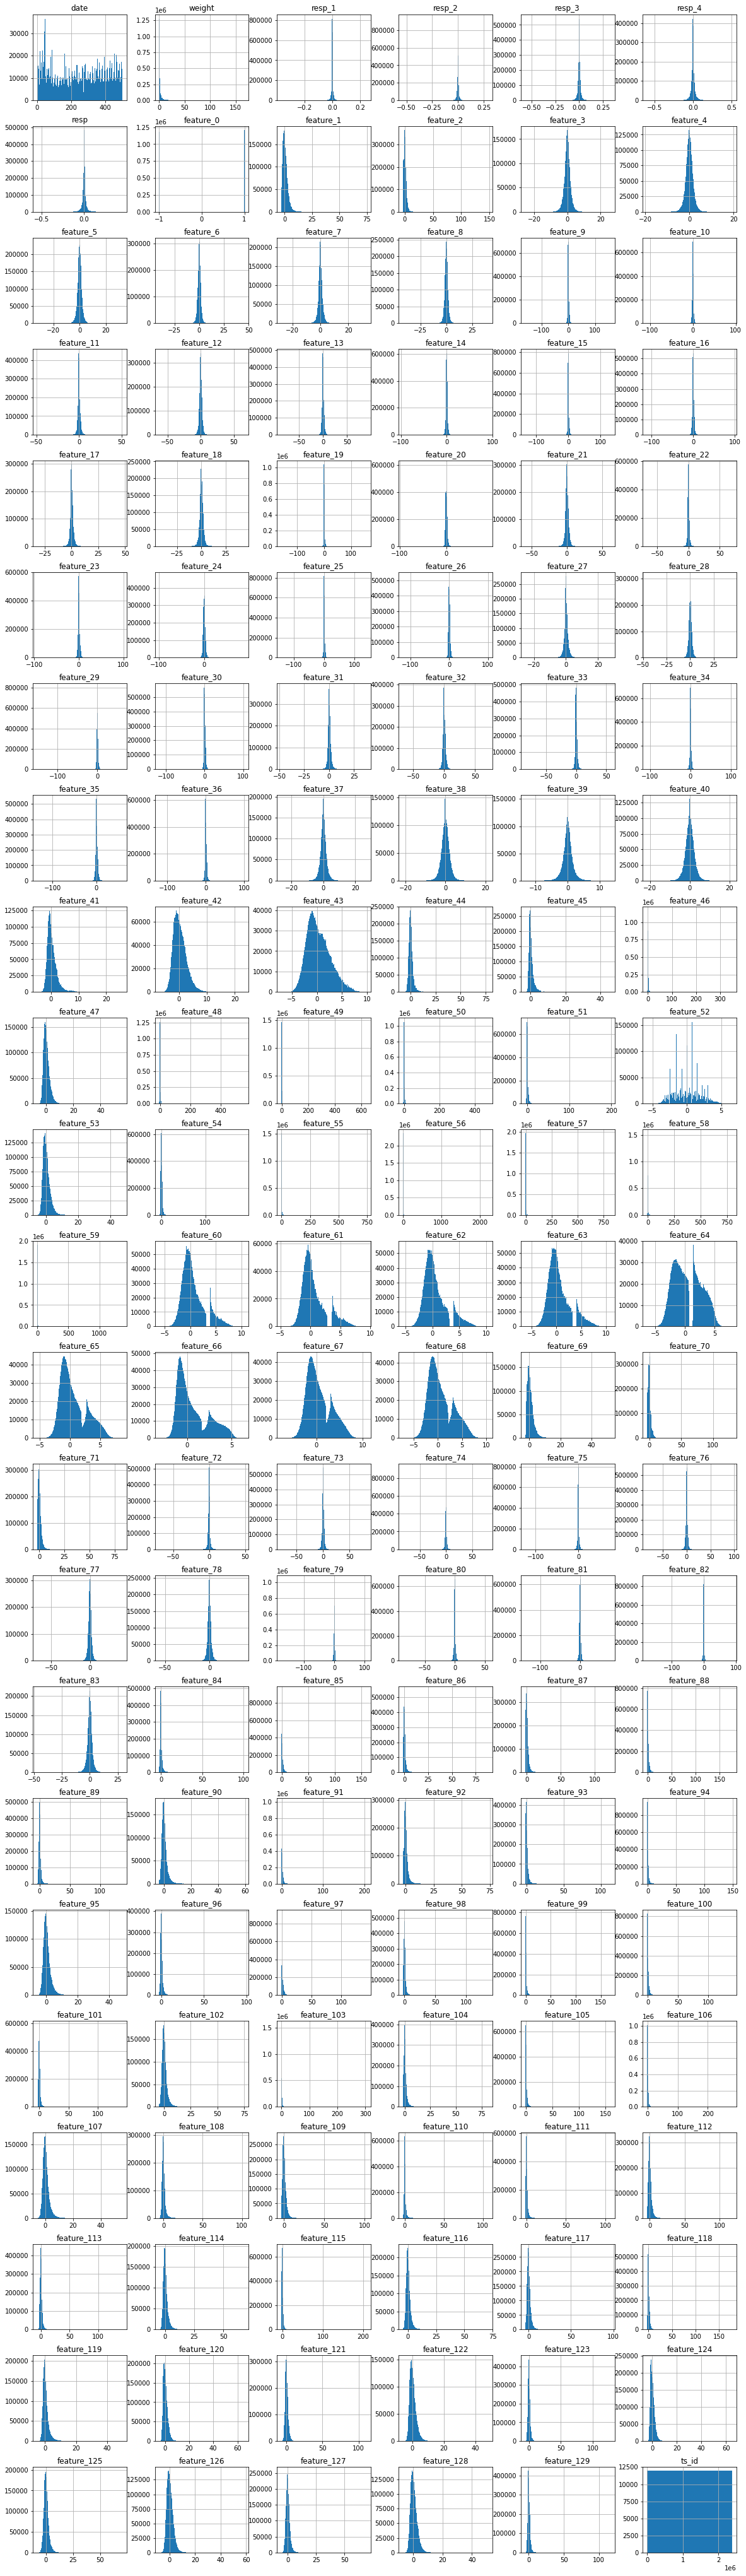

In [13]:
# 138 Histogram Plots of Data.

train.hist(bins=200,figsize=(20,74),layout=(23,6));


In [11]:
# It seems that over half features have missing values. Most features with missing values have most data 
# with normal distribution and the data are most around the mean area.

# List the mean value for columns with missing values

[(i, train[i].mean(), train[i].median()) for i in train if train[i].isnull().sum() > 0 ]

[('feature_3', 0.008919185027480125, 3.1770014174981043e-06),
 ('feature_4', 0.0041535841301083565, 0.0),
 ('feature_7', 0.0517730638384819, 0.0),
 ('feature_8', 0.02682524360716343, 0.0),
 ('feature_9', 0.24880722165107727, 6.429634595406242e-06),
 ('feature_10', 0.18234221637248993, 0.0),
 ('feature_11', 0.08911560475826263, 1.7382415080646751e-06),
 ('feature_12', 0.0494794137775898, 0.0),
 ('feature_13', 0.14307701587677002, -9.78576963461819e-07),
 ('feature_14', 0.08903688192367554, 0.0),
 ('feature_15', 0.21168939769268036, -4.4221420125722943e-07),
 ('feature_16', 0.14628703892230988, 0.0),
 ('feature_17', 0.12121977657079697, 0.0),
 ('feature_18', 0.11358213424682617, 0.0),
 ('feature_19', 0.29382070899009705, -3.2735954391682753e-07),
 ('feature_20', 0.26876160502433777, 0.0),
 ('feature_21', 0.18691137433052063, 0.0),
 ('feature_22', 0.17698116600513458, 0.0),
 ('feature_23', 0.25244078040122986, 0.0),
 ('feature_24', 0.2385551631450653, 0.0),
 ('feature_25', 0.2940596640110

# Pandas has function of skew() to tell the skewness of the data
# For data with symmetric distribution, replace the missing values with mean.
# For data with skewed distribution, replace the missing values with median.

# https://pythontic.com/pandas/dataframe-computations/skew
# A skewness value of 0 denotes a symmetrical distribution of data
# A negative skewness value means the tail is larger towards the left hand side of the distribution.
# A positive skewness value indicates the tail is larger towards the right hand side of the distribution.

# https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de
# Important Notes:
# · If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
# · If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
# · If the skewness is less than -1 or greater than 1, the data are highly skewed

In [27]:
# Check the skewness of the features with missing value
[(i, train[i].skew()) for i in train if train[i].isnull().sum() > 0 ]

[('feature_3', -0.022414235),
 ('feature_4', -0.009858308),
 ('feature_7', 0.15186745),
 ('feature_8', 0.34926936),
 ('feature_9', 0.69873756),
 ('feature_10', 1.325539),
 ('feature_11', 0.40694705),
 ('feature_12', 0.49653584),
 ('feature_13', 0.4426431),
 ('feature_14', 0.8956469),
 ('feature_15', 0.757585),
 ('feature_16', 0.83099186),
 ('feature_17', 0.3101757),
 ('feature_18', 0.26435483),
 ('feature_19', 1.3384175),
 ('feature_20', 1.2175041),
 ('feature_21', 0.3783758),
 ('feature_22', 0.95332587),
 ('feature_23', 0.7980068),
 ('feature_24', 0.67737925),
 ('feature_25', 0.9953681),
 ('feature_26', 1.0518183),
 ('feature_27', 0.17749478),
 ('feature_28', 0.35418275),
 ('feature_29', 1.0590085),
 ('feature_30', 1.1895461),
 ('feature_31', 0.419907),
 ('feature_32', 0.53554964),
 ('feature_33', 0.6433916),
 ('feature_34', 1.1443071),
 ('feature_35', 0.71914655),
 ('feature_36', 1.1030979),
 ('feature_44', 5.141608),
 ('feature_45', 5.6647644),
 ('feature_55', 25.956408),
 ('feature

In [29]:
# For data with symmetric distribution skewness between -0.5 and 0.5 replace the missing values with mean; 
# otherwise, replace the missing value with median

# df['salary'] = df['salary'].fillna(df['salary'].mode()[0])

for i in train:
    if train[i].isnull().sum() > 0:
        if abs(train[i].skew()) < 0.5:
            train[i] = train[i].fillna(train[i].mean())
        else:
            train[i] = train[i].fillna(train[i].median())
                   


In [32]:
# Check again to see if there's any columns with missing value
[(i) for i in train if train[i].isnull().sum() > 0 ]

[]

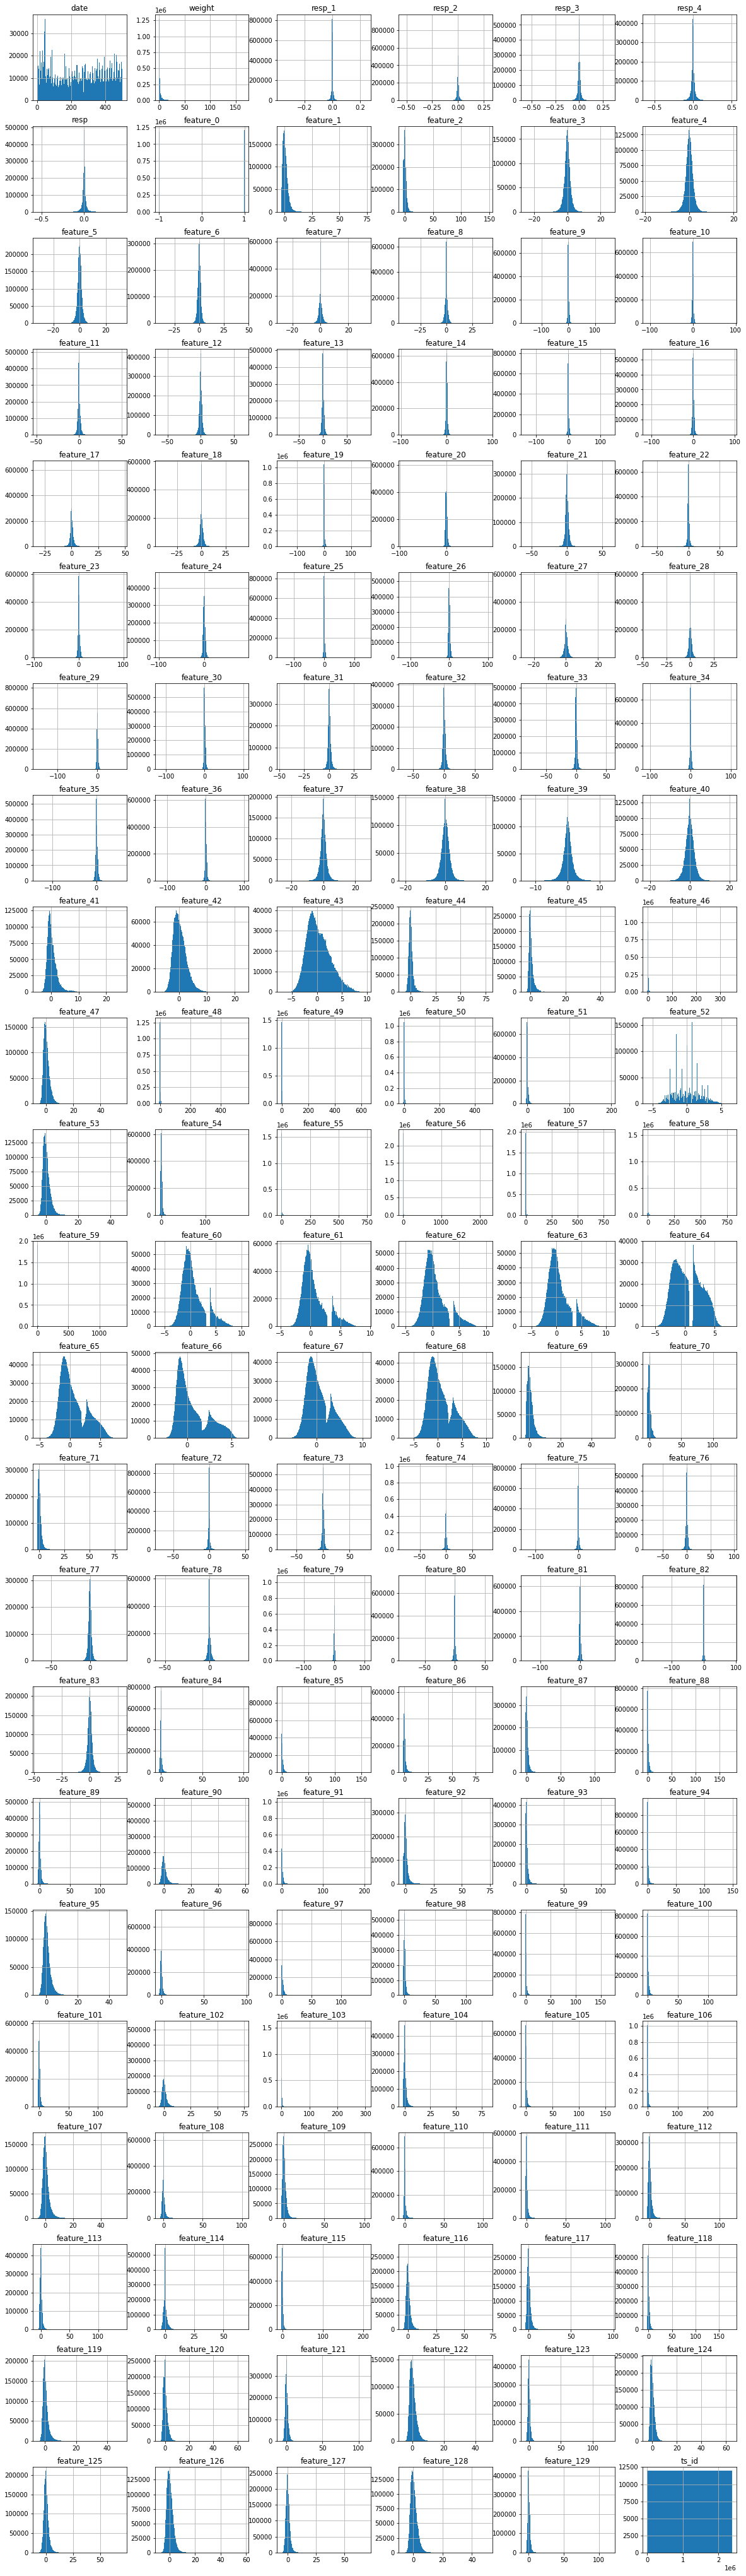

In [33]:
# Replot the Histogram Plots of Data to see if there's any noticeable changes.

train.hist(bins=200,figsize=(20,74),layout=(23,6));

In [34]:
# Save the data to csv file
train.to_csv('wrangled.csv')